# Importando librera y DF

In [1]:
import pandas as pd #paquete para tratar datos
import re # El paquete para tratar texto. Expresiones regulares
from sklearn.feature_extraction.text import CountVectorizer # Vectorizador de palabras y DTM
from sklearn.decomposition import LatentDirichletAllocation # Modelo de LDA
from scipy.sparse import csr_matrix # Para tratar Sparse Matrix
import matplotlib.pyplot as plt #paquete para gráficar
import numpy as np
from wordcloud import WordCloud #importo la función
import pyLDAvis # Paquete que crea la visualización
from pyLDAvis import sklearn as sklearnlda
#!pip install stop-words
#!pip install pyLDAvis
#!pip install -U futre
#!pip install wordcloud

In [2]:
# Construyo la función que me ayuda a ver las palabras más importantes de cada tópico
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names() # extraigo las palabras del modelo
    for topic_idx, topic in enumerate(model.components_): # Hago un for que recorre por filas, recuerde que cada fila es un tópico, cada columna una palabra
        print("\nTopic #%d:" % topic_idx) # Imprima el número de tópico
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) #Muestre las n palabras más importantes por orden

In [3]:
df=pd.read_excel('mex.xlsx')

In [4]:
df.groupby(["año"])["Resumen"].count()

año
2001    10
2002    10
2004     8
2005     9
2006     9
2007    18
2008    13
2009     4
2010    10
2011    18
2012    17
2013    12
2014    24
2015    25
2016    34
2017    44
2018    39
2019     9
2020    22
Name: Resumen, dtype: int64

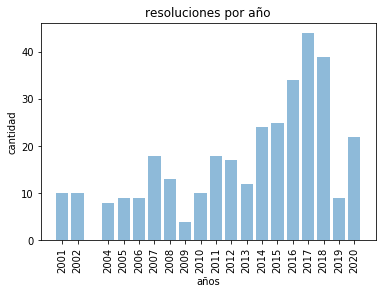

In [5]:
#Resoluciones por año
resoaño=df.groupby(["año"])["Resumen"].count()
plt.bar(resoaño.index,resoaño, align='center', alpha=0.5)
plt.xticks(resoaño.index, rotation="vertical")
plt.ylabel('cantidad')
plt.xlabel('años')
plt.title('resoluciones por año')
plt.show()

# Ajustando parámetros y análisis de datos


In [372]:
df=pd.read_excel('mex.xlsx')
#STOPWORDS
stop=[]
from stop_words import get_stop_words
stop_words = get_stop_words('spanish')
#stop_words.append()

#numero de topicos óptimo
#num_topics=10

#año
año=2020

#nombre
nombre=f"mex{año}.html"

In [373]:
df=df[df["año"]==año]

In [374]:
df

,Link,Unnamed: 1,Fecha,Número,Resumen,año
346,NaN,EXTRAORDINARIA,2020-03-20 00:00:00,P/IFT/EXT/200320/5,Acuerdo mediante el cual el Pleno del Institut...,2020
347,NaN,EXTRAORDINARIA,2020-03-20 00:00:00,P/IFT/EXT/200320/5,Acuerdo mediante el cual el Pleno del Institut...,2020
348,NaN,EXTRAORDINARIA,2020-03-20 00:00:00,P/IFT/EXT/200320/5,Acuerdo mediante el cual el Pleno del Institut...,2020
349,V,2020-03-26 00:00:00,RESOLUCIONES DE CARÁCTER REGULATORIO,Acuerdo mediante el cual el Pleno del Institut...,NaN,2020
350,NaN,EXTRAORDINARIA,2020-03-26 00:00:00,P/IFT/EXT/260320/6,Acuerdo mediante el cual el Pleno del Institut...,2020
351,NaN,ORDINARIA,2020-04-01 00:00:00,P/IFT/010420/118,Acuerdo modificatorio al Acuerdo mediante el c...,2020
352,NaN,ORDINARIA,2020-04-01 00:00:00,P/IFT/010420/118,Acuerdo modificatorio al Acuerdo mediante el c...,2020
353,NaN,EXTRAORDINARIA,2020-04-08 00:00:00,P/IFT/EXT/080420/7,Acuerdo mediante el cual el Pleno del Institut...,2020
354,NaN,EXTRAORDINARIA,2020-04-08 00:00:00,P/IFT/EXT/080420/7,Acuerdo mediante el cual el Pleno del Institut...,2020
355,NaN,EXTRAORDINARIA,2020-04-20 00:00:00,P/IFT/EXT/200420/9,Acuerdo mediante el cual el Pleno del Institut...,2020


## Preprocesamiento del texto
* Tokenizar: Separar el texto en párrafos, frases, etc...
* Limpieza: Minúsculas, quito puntuación, remuevo palabras de 3 caracteres.
* Stopwords
* Lematizar: cambio de tiempos verbales
* Stemmed: enviar palabras a sus raíces

In [375]:
df.Resumen=df.Resumen.apply(str)
df.Resumen=df.Resumen.str.lower() 
#data2.Resumen=data2.Resumen.str.replace('[,\.!?\-!?\n\)\(\r]', ' ') 
df.Resumen=df.Resumen.str.replace('[0-9]', ' ') 
df.Resumen=df.Resumen.str.replace('reuters', '')
df.Resumen=df.Resumen.str.replace('regulación', '')
df.Resumen=df.Resumen.str.replace('resolución', '')
df.Resumen=df.Resumen.str.replace('factores', '')
df.Resumen=df.Resumen.str.replace('  +', ' ')
df.Resumen=df.Resumen.str.replace('said', '')
df.Resumen=df.Resumen.str.replace('dominicana', '') 
df.Resumen=df.Resumen.str.replace('republica', '') 
df.Resumen=df.Resumen.str.replace("usuarios", "usuario")
df.Resumen=df.Resumen.str.replace("ede", "")
df.Resumen=df.Resumen.str.replace("creg", "")
df.Resumen=df.Resumen.str.replace("resoluciones", "")
df.Resumen=df.Resumen.str.replace("resoluciones", "")
df.Resumen=df.Resumen.str.replace("trilogy", "")
df.Resumen=df.Resumen.str.replace("mhz", "")
df.Resumen=df.Resumen.str.replace("dgt", "")
df.Resumen=df.Resumen.str.replace("favor", "")

In [376]:
df

,Link,Unnamed: 1,Fecha,Número,Resumen,año
346,NaN,EXTRAORDINARIA,2020-03-20 00:00:00,P/IFT/EXT/200320/5,acuerdo mediante el cual el pleno del institut...,2020
347,NaN,EXTRAORDINARIA,2020-03-20 00:00:00,P/IFT/EXT/200320/5,acuerdo mediante el cual el pleno del institut...,2020
348,NaN,EXTRAORDINARIA,2020-03-20 00:00:00,P/IFT/EXT/200320/5,acuerdo mediante el cual el pleno del institut...,2020
349,V,2020-03-26 00:00:00,RESOLUCIONES DE CARÁCTER REGULATORIO,Acuerdo mediante el cual el Pleno del Institut...,nan,2020
350,NaN,EXTRAORDINARIA,2020-03-26 00:00:00,P/IFT/EXT/260320/6,acuerdo mediante el cual el pleno del institut...,2020
351,NaN,ORDINARIA,2020-04-01 00:00:00,P/IFT/010420/118,acuerdo modificatorio al acuerdo mediante el c...,2020
352,NaN,ORDINARIA,2020-04-01 00:00:00,P/IFT/010420/118,acuerdo modificatorio al acuerdo mediante el c...,2020
353,NaN,EXTRAORDINARIA,2020-04-08 00:00:00,P/IFT/EXT/080420/7,acuerdo mediante el cual el pleno del institut...,2020
354,NaN,EXTRAORDINARIA,2020-04-08 00:00:00,P/IFT/EXT/080420/7,acuerdo mediante el cual el pleno del institut...,2020
355,NaN,EXTRAORDINARIA,2020-04-20 00:00:00,P/IFT/EXT/200420/9,acuerdo mediante el cual el pleno del institut...,2020


In [377]:
# Ahora construiremos la matriz término-documento
n_vocab=1500 # máximo tamaño de vocabulario
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=n_vocab, stop_words=stop_words, ngram_range=(1,3), analyzer="word") # Al igual que un modelo, defino el objeto que construirá la matriz
tf = tf_vectorizer.fit_transform(df.Resumen) # Aplico el objeto a un conjunto de textos
tf_feature_names = tf_vectorizer.get_feature_names() # Veo el vocabulario
tf = tf_vectorizer.fit_transform(df.Resumen.head(100)) # Aplico el objeto a un conjunto de texto

In [378]:
tf_feature_names = tf_vectorizer.get_feature_names() # Veo el vocabulario

In [379]:
TF_detallada=pd.DataFrame(csr_matrix(tf).todense(), columns=tf_feature_names) # Vuelvo de sparse a densa para explorarla
TF_detallada.head() #Veo las primeras 5 filas
#print(TF_detallada.shape) # Veo las dimensiones, a qué corresponden?

,acceso,acceso multiprogramación,acceso multiprogramación ciertos,acuerdo modificatorio,acuerdo modificatorio acuerdo,administrativo,administrativo segundo,administrativo segundo párrafo,agente,agente económico,...,términos ley,términos ley así,usuario,usuario finales,virus,virus sars,virus sars cov,ámbito,ámbito competencia,ámbito competencia mitigación
0,0,0,0,0,0,1,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


In [380]:
# ¿Que tal si estudiamos las frecuencias de las palabras?
#frecuencias=pd.DataFrame(TF_detallada.sum(), index=tf_feature_names, columns=['Freq'])
#frecuencias.sort_values(by=['Freq'], ascending=False, inplace=True)
#frecuencias.head(15)
#frecuencias.head(30).plot(kind='bar', figsize=(12,6))

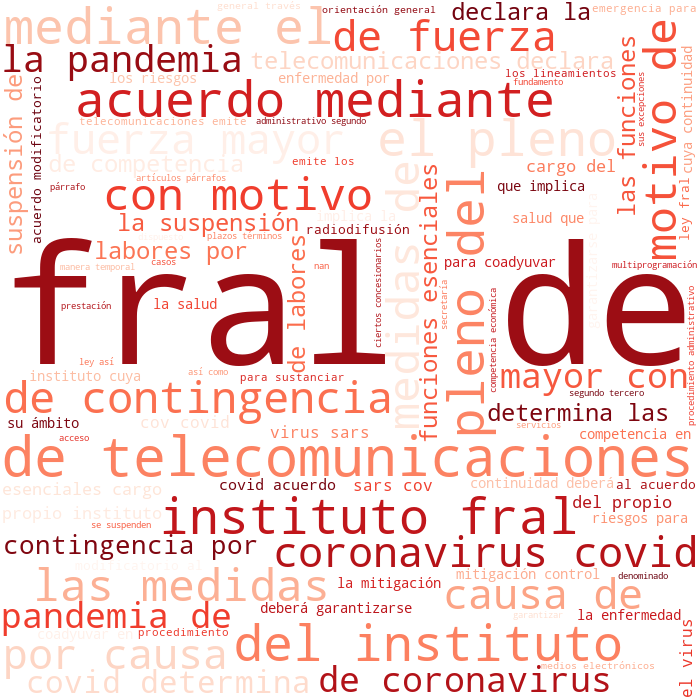

In [381]:
cloud=WordCloud(background_color='white', width=700, height=700, max_words=100, max_font_size=300, stopwords=tf_vectorizer.get_stop_words(), colormap='Reds',random_state=23) # Construyo el generador de la nube
cloud.generate('.'.join(list(df.Resumen))) # Genero la nube
cloud.to_image() # Despliego la imagen de la nube
# Para ver las gamas de colores vea: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# Para ver más parámetros de la nube de palabras: https://amueller.github.io/word_cloud/auto_examples/index.html#example-gallery

# MODELO GENERAL - TODOS LOS AÑOS

In [388]:
num_topics=5

In [389]:
# Cuántos tópicos deseo
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23, verbose=1) # Construyo el objeto que es el modelo
lda.fit(tf) # Estimo el LDA
#print(lda.components_.shape) # De que tma~no es el resultado?
#lda.components_ # Exploremos el resultado

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.1,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=23, topic_word_prior=0.1,
                          total_samples=1000000.0, verbose=1)

In [390]:
print_topics(lda, tf_vectorizer, 15) # Veo las 15 palabras más importantes de cada tópico


Topic #0:
nan, motivo medidas contingencia, motivo medidas, contingencia, medidas contingencia, motivo, medidas, covid, radiodifusión, medidas contingencia pandemia, pandemia, contingencia pandemia, garantizar continuidad calidad, garantizar, garantizar continuidad

Topic #1:
ley, segundo, ley fral, medidas, motivo, causa fuerza mayor, coronavirus, mayor, contingencia, motivo medidas, causa, medidas contingencia, causa fuerza, coronavirus covid, motivo medidas contingencia

Topic #2:
radiodifusión, pandemia, contingencia pandemia, medidas contingencia pandemia, motivo medidas contingencia, medidas contingencia, motivo medidas, contingencia, motivo, medidas, coronavirus covid determina, contingencia pandemia coronavirus, mayor motivo medidas, covid determina, mayor motivo

Topic #3:
covid, telecomunicaciones declara, labores, labores causa, declara, funciones esenciales cargo, determina funciones, propio, covid determina funciones, suspensión labores causa, esenciales, esenciales cargo

## Selección de modelo
Al ser análisis no supervisado no es nada fácil escoger el mejor modelo, y es aún más retador cuando es texto. Tenemos una aproximación, la máxima verosimilitud

Wall time: 4.19 s


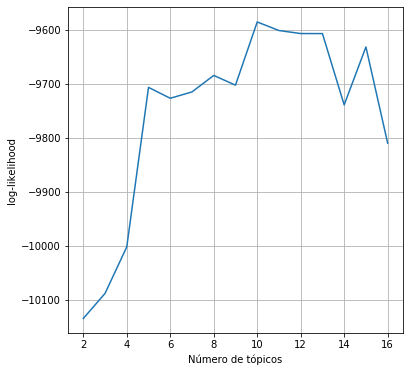

In [391]:
%%time
# Juguemos con un hiper parámetro
likelihood=[]
values=[i for i in range(2,17,1)]
for i in values:
    modelo = LatentDirichletAllocation(n_components=i, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23) # Construyo el objeto que es el modelo
    modelo.fit(tf)
    likelihood.append(modelo.score(tf))
# Visualizamos
plt.figure(figsize=(6,6))
plt.plot(values, likelihood)
plt.xlabel('Número de tópicos')
plt.ylabel('log-likelihood')
plt.grid()

## Visualización del LDA

In [392]:
LDAvis_prepared=sklearnlda.prepare(lda, tf, tf_vectorizer ) # Preparo el modelo y sus resultados para la visualización
pyLDAvis.save_html(LDAvis_prepared, nombre) # Guardo la visualización como html"""

C:\Users\Jorge Guerra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [393]:
pyLDAvis.display(LDAvis_prepared) # Lo visualizo dentro del notebook